# Jackknife Notebook
En el siguiente notebook podrá encontrar la implementación de la técnica de Jackknife para el caso de uso de "*Ocupación de UCI*". 

**Enunciado:** Dados los datos de ocupación de camas UCI proporcionados por la Secretaría Distrital de Salud en el archivo *“UCI.csv”*, encontrar una estimación insesgada puntual y de intervalo del parámetro de la media muestral.

**Solución:** Primeramente, es necesario importar los datos desde el CSV y leerlos por medio de un DataFrame. 

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import scipy.stats

df = pd.read_csv("UCI.csv", on_bad_lines="skip", encoding='latin-1', delimiter=";", decimal=",")
df

,Fecha,Camas UCI ocupadas Covid-19,Total camas UCI COVID 19 reportadas por IPS,Ocupación UCI COVID 19
0,8/04/2020,106,543,"19,50%"
1,9/04/2020,136,608,"22,40%"
2,10/04/2020,150,596,"25,20%"
3,11/04/2020,148,597,"24,80%"
4,12/04/2020,178,576,"30,90%"
...,...,...,...,...
755,19/05/2022,177,461,"38,39%"
756,26/05/2022,167,379,"44,06%"
757,2/06/2022,180,379,"47,49%"
758,9/06/2022,201,374,"53,74%"


El DataFrame cuenta con 760 datos. La columna de interés es *Camas UCI ocupadas Covid - 19*. 

Posteriormente, se procederá a la limpieza de datos para la posterior implemetación de la técnica de *Jackknife*. 

In [37]:
df.columns = [0,1,2,3]
df[1] = df[1].apply(lambda x: int(x.replace(".","")))
df[2] = df[2].apply(lambda x: int(x.replace(".","")))

Como adición se mostrará el comportamiento de los datos a lo largo del tiempo gráficamente para lograr una mejor comprensión del suceso.

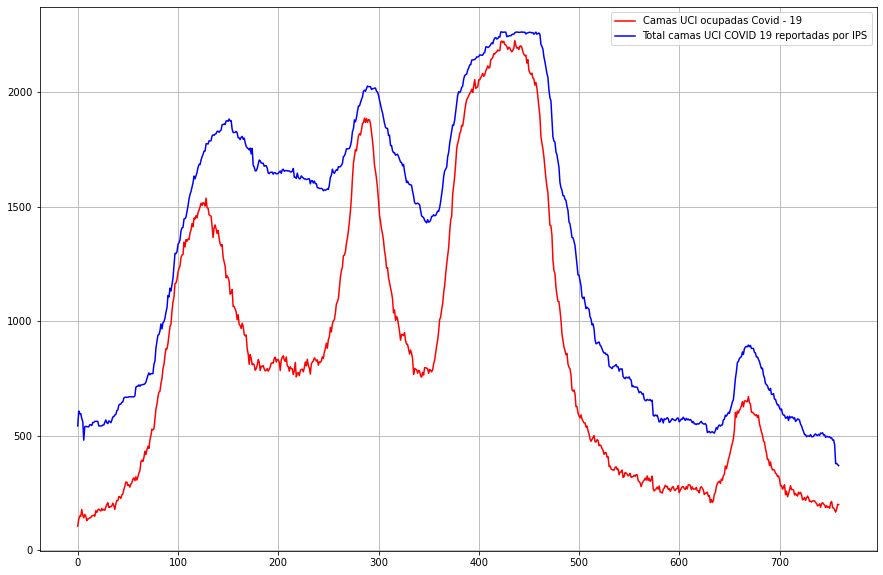

In [38]:
plt.figure(figsize=(15,10))
plt.plot(range(0,760) ,df[1], color="red")
plt.plot(range(0,760) ,df[2], color="blue")
plt.legend(["Camas UCI ocupadas Covid - 19", "Total camas UCI COVID 19 reportadas por IPS"])
plt.grid()
plt.show()

Ya realizada esta introducción, se procederá a implementar el método de *Jackniffe*. De primera mano, se encontrarán los
*estadísticos de Jackniffe*. 

In [39]:
t_i = list()
for i in range(0, df.shape[0]):
    suma = df[1].sum() - df[1][i]
    t_i.append(suma/(df.shape[0]-1))
df_1 = pd.DataFrame(t_i)
df_1.rename(columns={0:"t_n-1,i"}, inplace=True)
df_1

,"t_n-1,i"
0,865.725955
1,865.686430
2,865.667984
3,865.670619
4,865.631094
...,...
755,865.632411
756,865.645586
757,865.628458
758,865.600791


Una vez realizado este paso, únicamente hace falta aplicar la fórmula para encontrar la *estimación de Jackknife*.  

In [40]:
n = df.shape[0]
print(f"La estimación de Jackknife del parámetro es: {df[1].mean()*n - df_1['t_n-1,i'].mean()*(n-1)}")

La estimación de Jackknife del parámetro es: 864.7263157891575


Se ha obtenido una estimación **PUNTUAL**, ahora se estudiará su sesgo. Asi, aplicando la fórmula para el sesgo:

In [41]:
print(f"La estimación de Jackknife del sesgo es: {(n-1)*df_1['t_n-1,i'].mean() - (n-1)*df[1].mean()}")

La estimación de Jackknife del sesgo es: 3.4924596548080444e-10


Visto lo anterior, es claro que se ha obtenido estimador con un sesgo muy bajo que sera muy util de caso de realizar estudios relacionados con esta medida de la media. Si se realiza un contraste entre estimador de la media y la media muestral, observe que:

In [42]:
print(f"El error es de: {df[1].mean() - df[1].mean()*n + df_1['t_n-1,i'].mean()*(n-1)}")

El error es de: 3.4924596548080444e-10


Una cantidad de orden $10^{-10}$ muy pequeña, casi despreciable. 

Ahora, se encontrará una estimación por intervalo del parámetro. Para esto es  necesario los *pseudo-valores de Jackknife* por ende, 


In [43]:
j_i = list()
for i in range(0, df.shape[0]):
    j_i.append(df[1].sum() - (n-1)*df_1['t_n-1,i'][i])
df_1["j_n,i"] = j_i
df_1

,"t_n-1,i","j_n,i"
0,865.725955,106.0
1,865.686430,136.0
2,865.667984,150.0
3,865.670619,148.0
4,865.631094,178.0
...,...,...
755,865.632411,177.0
756,865.645586,167.0
757,865.628458,180.0
758,865.600791,201.0


In [47]:
print(f"El estimador de varianza de Jackknife es: {df_1['j_n,i'].var()}")

El estimador de varianza de Jackknife es: 376881.25833159947


De esta mánera por medio de la $t-student$ es posible plantear un intervalo de confianza. Por cuestiones estándar, se estipulará $\alpha = 0.05$. Definiendo $IC_{0.95} = (T_n - t_{\frac{0.05}{2}, 759}\cdot\sqrt{v_J}, T_n + t_{\frac{0.05}{2}, 759}\cdot\sqrt{v_J})$. 


In [46]:
t_critic = scipy.stats.t.ppf(0.05/2, df.shape[0]-1)
print(f"El intervalo de confianza es: ({df[1].mean()*n - (n-1)*df_1['t_n-1,i'].mean() + t_critic*df_1['j_n,i'].std()}, {df[1].mean()*n - (n-1)*df_1['t_n-1,i'].mean()- t_critic*df_1['j_n,i'].std()}) ")

El intervalo de confianza es: (-340.43021186464784, 2069.882843442963) 


Así culmina el ejercicio obteniendo una estimación por intervalo. 